In [1]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#Limit GPU Memory Growth to only what's needed
import tensorflow as tf 
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Failed to limit GPU memory')

In [3]:
#Gather Pre-proccessed images 

train_path = 'dataset-classification/train-segmented'
valid_path = 'dataset-classification/validate-segmented'

train_generator = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256))
valid_generator = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256))


Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [4]:
#Build Model 

base_model = MobileNetV3Large(weights='imagenet', include_top = False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs = preds)


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

 thwiseConv2D)                  72)                                                               
                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, None, None,   288        ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)     72)                              ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, None, None,   0           ['expanded_conv_2/depthwise/Batch
                                72)                              Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, None, None,   1728       ['re_lu_5[0][0]']                
 D)                             24)                                                               
          

 hNorm (BatchNormalization)     120)                             ']                               
                                                                                                  
 re_lu_10 (ReLU)                (None, None, None,   0           ['expanded_conv_4/depthwise/Batch
                                120)                             Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Co

 D)                             40)                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_5/project/BatchN  (None, None, None,   160        ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)       40)                                                               
                                                                                                  
 expanded_conv_5/Add (Add)      (None, None, None,   0           ['expanded_conv_4/Add[0][0]',    
                                40)                               'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, None, None,   9600       ['expanded_conv_5/Add[0][0]']    
 )        

                                                                                                  
 re_lu_18 (ReLU)                (None, None, None,   0           ['tf.__operators__.add_7[0][0]'] 
                                200)                                                              
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None, None, None,   0          ['re_lu_18[0][0]']               
 )                              200)                                                              
                                                                                                  
 multiply_4 (Multiply)          (None, None, None,   0           ['expanded_conv_7/depthwise/Batch
                                200)                             Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
          

 a)                             184)                                                              
                                                                                                  
 multiply_7 (Multiply)          (None, None, None,   0           ['expanded_conv_9/expand/BatchNor
                                184)                             m[0][0]',                        
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 expanded_conv_9/depthwise (Dep  (None, None, None,   1656       ['multiply_7[0][0]']             
 thwiseConv2D)                  184)                                                              
                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, None, None,   736        ['expanded_conv_9/depthwise[0][0]
 hNorm (Ba

 expanded_conv_10/squeeze_excit  (None, 1, 1, 480)   58080       ['expanded_conv_10/squeeze_excite
 e/Conv_1 (Conv2D)                                               /Relu[0][0]']                    
                                                                                                  
 tf.__operators__.add_14 (TFOpL  (None, 1, 1, 480)   0           ['expanded_conv_10/squeeze_excite
 ambda)                                                          /Conv_1[0][0]']                  
                                                                                                  
 re_lu_25 (ReLU)                (None, 1, 1, 480)    0           ['tf.__operators__.add_14[0][0]']
                                                                                                  
 tf.math.multiply_14 (TFOpLambd  (None, 1, 1, 480)   0           ['re_lu_25[0][0]']               
 a)                                                                                               
          

 2D)                            112)                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_11/project/Batch  (None, None, None,   448        ['expanded_conv_11/project[0][0]'
 Norm (BatchNormalization)      112)                             ]                                
                                                                                                  
 expanded_conv_11/Add (Add)     (None, None, None,   0           ['expanded_conv_10/project/BatchN
                                112)                             orm[0][0]',                      
                                                                  'expanded_conv_11/project/BatchN
                                                                 orm[0][0]']                      
                                                                                                  
 expanded_

                                                                                                  
 expanded_conv_13/expand/BatchN  (None, None, None,   3840       ['expanded_conv_13/expand[0][0]']
 orm (BatchNormalization)       960)                                                              
                                                                                                  
 tf.__operators__.add_21 (TFOpL  (None, None, None,   0          ['expanded_conv_13/expand/BatchNo
 ambda)                         960)                             rm[0][0]']                       
                                                                                                  
 re_lu_32 (ReLU)                (None, None, None,   0           ['tf.__operators__.add_21[0][0]']
                                960)                                                              
                                                                                                  
 tf.math.m

 tf.math.multiply_24 (TFOpLambd  (None, None, None,   0          ['re_lu_35[0][0]']               
 a)                             960)                                                              
                                                                                                  
 multiply_17 (Multiply)         (None, None, None,   0           ['expanded_conv_14/expand/BatchNo
                                960)                             rm[0][0]',                       
                                                                  'tf.math.multiply_24[0][0]']    
                                                                                                  
 expanded_conv_14/depthwise (De  (None, None, None,   24000      ['multiply_17[0][0]']            
 pthwiseConv2D)                 960)                                                              
                                                                                                  
 expanded_

                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          32896       ['dense_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 3)            387         ['dense_2[0][0]']                
                                                                                                  
Total params: 3,652,995
Trainable params: 3,628,595
Non-trainable params: 24,400
__________________________________________________________________________________________________


In [6]:
for layers in model.layers[:-50]:
    layers.trainable = False

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

 thwiseConv2D)                  72)                                                               
                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, None, None,   288        ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)     72)                              ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, None, None,   0           ['expanded_conv_2/depthwise/Batch
                                72)                              Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, None, None,   1728       ['re_lu_5[0][0]']                
 D)                             24)                                                               
          

 hNorm (BatchNormalization)     120)                             ']                               
                                                                                                  
 re_lu_10 (ReLU)                (None, None, None,   0           ['expanded_conv_4/depthwise/Batch
                                120)                             Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Co

 D)                             40)                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_5/project/BatchN  (None, None, None,   160        ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)       40)                                                               
                                                                                                  
 expanded_conv_5/Add (Add)      (None, None, None,   0           ['expanded_conv_4/Add[0][0]',    
                                40)                               'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, None, None,   9600       ['expanded_conv_5/Add[0][0]']    
 )        

                                                                                                  
 re_lu_18 (ReLU)                (None, None, None,   0           ['tf.__operators__.add_7[0][0]'] 
                                200)                                                              
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None, None, None,   0          ['re_lu_18[0][0]']               
 )                              200)                                                              
                                                                                                  
 multiply_4 (Multiply)          (None, None, None,   0           ['expanded_conv_7/depthwise/Batch
                                200)                             Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
          

 a)                             184)                                                              
                                                                                                  
 multiply_7 (Multiply)          (None, None, None,   0           ['expanded_conv_9/expand/BatchNor
                                184)                             m[0][0]',                        
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 expanded_conv_9/depthwise (Dep  (None, None, None,   1656       ['multiply_7[0][0]']             
 thwiseConv2D)                  184)                                                              
                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, None, None,   736        ['expanded_conv_9/depthwise[0][0]
 hNorm (Ba

 expanded_conv_10/squeeze_excit  (None, 1, 1, 480)   58080       ['expanded_conv_10/squeeze_excite
 e/Conv_1 (Conv2D)                                               /Relu[0][0]']                    
                                                                                                  
 tf.__operators__.add_14 (TFOpL  (None, 1, 1, 480)   0           ['expanded_conv_10/squeeze_excite
 ambda)                                                          /Conv_1[0][0]']                  
                                                                                                  
 re_lu_25 (ReLU)                (None, 1, 1, 480)    0           ['tf.__operators__.add_14[0][0]']
                                                                                                  
 tf.math.multiply_14 (TFOpLambd  (None, 1, 1, 480)   0           ['re_lu_25[0][0]']               
 a)                                                                                               
          

 2D)                            112)                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_11/project/Batch  (None, None, None,   448        ['expanded_conv_11/project[0][0]'
 Norm (BatchNormalization)      112)                             ]                                
                                                                                                  
 expanded_conv_11/Add (Add)     (None, None, None,   0           ['expanded_conv_10/project/BatchN
                                112)                             orm[0][0]',                      
                                                                  'expanded_conv_11/project/BatchN
                                                                 orm[0][0]']                      
                                                                                                  
 expanded_

                                                                                                  
 expanded_conv_13/expand/BatchN  (None, None, None,   3840       ['expanded_conv_13/expand[0][0]']
 orm (BatchNormalization)       960)                                                              
                                                                                                  
 tf.__operators__.add_21 (TFOpL  (None, None, None,   0          ['expanded_conv_13/expand/BatchNo
 ambda)                         960)                             rm[0][0]']                       
                                                                                                  
 re_lu_32 (ReLU)                (None, None, None,   0           ['tf.__operators__.add_21[0][0]']
                                960)                                                              
                                                                                                  
 tf.math.m

 tf.math.multiply_24 (TFOpLambd  (None, None, None,   0          ['re_lu_35[0][0]']               
 a)                             960)                                                              
                                                                                                  
 multiply_17 (Multiply)         (None, None, None,   0           ['expanded_conv_14/expand/BatchNo
                                960)                             rm[0][0]',                       
                                                                  'tf.math.multiply_24[0][0]']    
                                                                                                  
 expanded_conv_14/depthwise (De  (None, None, None,   24000      ['multiply_17[0][0]']            
 pthwiseConv2D)                 960)                                                              
                                                                                                  
 expanded_

                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          32896       ['dense_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 3)            387         ['dense_2[0][0]']                
                                                                                                  
Total params: 3,652,995
Trainable params: 2,227,363
Non-trainable params: 1,425,632
__________________________________________________________________________________________________


In [8]:
epochs = 50

optimizer = Adam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

history = model.fit(train_generator, validation_data=valid_generator, epochs = epochs)

Epoch 1/50
75/75 [==============================] - 48s 223ms/step - loss: 0.5021 - accuracy: 0.8075 - val_loss: 0.8814 - val_accuracy: 0.6133
Epoch 2/50
75/75 [==============================] - 9s 124ms/step - loss: 0.0954 - accuracy: 0.9708 - val_loss: 0.7808 - val_accuracy: 0.6467
Epoch 3/50
75/75 [==============================] - 9s 124ms/step - loss: 0.0306 - accuracy: 0.9946 - val_loss: 0.7077 - val_accuracy: 0.7000
Epoch 4/50
75/75 [==============================] - 10s 126ms/step - loss: 0.0122 - accuracy: 0.9979 - val_loss: 0.8532 - val_accuracy: 0.6833
Epoch 5/50
75/75 [==============================] - 11s 150ms/step - loss: 0.0051 - accuracy: 0.9996 - val_loss: 0.4745 - val_accuracy: 0.8000
Epoch 6/50
75/75 [==============================] - 10s 127ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.3622 - val_accuracy: 0.8667
Epoch 7/50
75/75 [==============================] - 10s 130ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.4473 - val_accuracy: 0.8300
E

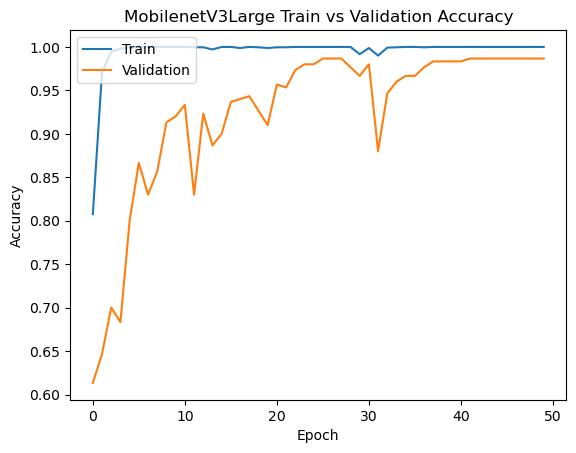

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobilenetV3Large Train vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

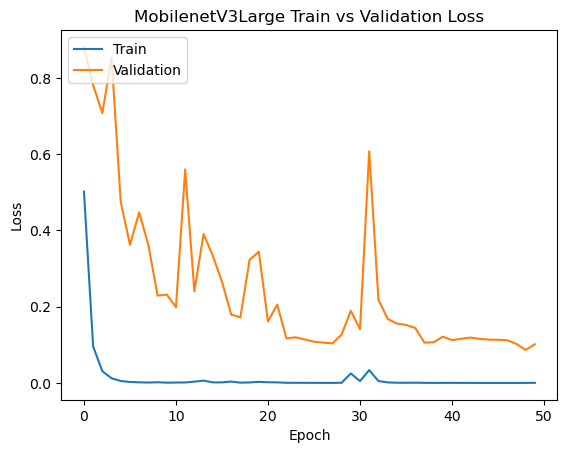

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobilenetV3Large Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [11]:
test_path = 'dataset-classification/test-segmented'
test_generator = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256))
predictions = model.predict(x = test_generator, verbose = 0)

Found 300 images belonging to 3 classes.


In [12]:
test_labels = test_generator.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
test_generator.class_indices

{'-K': 0, '-N': 1, 'FN': 2}

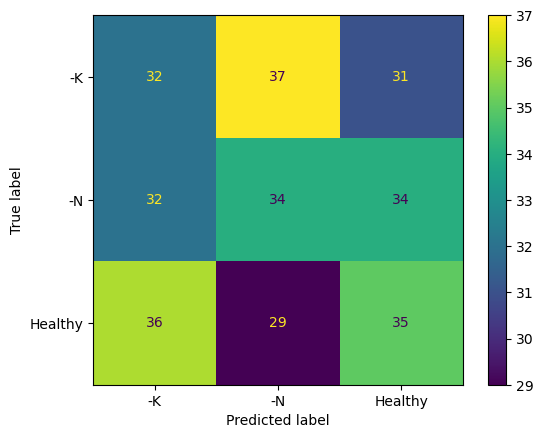

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-K', '-N', 'Healthy'])
disp.plot()
plt.show()

In [14]:
from sklearn.metrics import classification_report 

print(classification_report(test_labels,predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.32      0.32      0.32       100
           1       0.34      0.34      0.34       100
           2       0.35      0.35      0.35       100

    accuracy                           0.34       300
   macro avg       0.34      0.34      0.34       300
weighted avg       0.34      0.34      0.34       300



In [15]:
#model.save("MNetLarge.h5")